# Laboratorio 7 - Deep Reinforcement Learning
**Universidad del Valle de Guatemala**\
**Facultad de Ingeniería**\
**Departamento de Ciencias de la Computación**\
**Deep Learning**
---
Integrantes:
- Diego Leiva
- Pablo Orellana
- Maria Marta Ramirez
- Gabriel Garcia
- Luis Montenegro

## 1. Instalar Librerias

In [26]:
!pip install gymnasium numpy torch

You should consider upgrading via the 'c:\users\gegdg\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


## 2. Crear entorno CartPole

In [27]:
import gymnasium as gym
import numpy as np

env = gym.make('CartPole-v1')


## 3. Definir las redes en linea y de destino

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Inicializar las redes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

online_net = QNetwork(state_size, action_size)
target_net = QNetwork(state_size, action_size)
target_net.load_state_dict(online_net.state_dict())  # La red de destino comienza con los mismos pesos

<All keys matched successfully>

## 4. Establecer Hiperparametros

In [29]:
gamma = 0.99  # Factor de descuento
epsilon = 1.0  # Tasa de exploración
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
learning_rate = 0.001
num_episodes = 500
update_target_every = 10  # Actualiza la red de destino cada N episodios

optimizer = optim.Adam(online_net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

## 5. Selección de Acciones con Epsilon-Greedy

In [30]:
def epsilon_greedy_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()  # Acción aleatoria
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = online_net(state)
        return torch.argmax(action_values).item()  # Mejor acción


## 6. Reproducción de la Experiencia (Experience Replay)

In [31]:
from collections import deque
import random

replay_memory = deque(maxlen=2000)

def add_experience(experience):
    replay_memory.append(experience)

def sample_experience(batch_size):
    return random.sample(replay_memory, batch_size)


## 7. Bucle de Entrenamiento

In [32]:
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        add_experience((state, action, reward, next_state, done))

        state = next_state

        if len(replay_memory) > batch_size:
            experiences = sample_experience(batch_size)
            states, actions, rewards, next_states, dones = zip(*experiences)
            
            # Convertir a tensores
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards = torch.FloatTensor(rewards).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Actualización Q-learning
            q_values = online_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (gamma * next_q_values * (1 - dones))

            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    # Actualizar la red de destino
    if episode % update_target_every == 0:
        target_net.load_state_dict(online_net.state_dict())

    # Reducir epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episodio {episode}, Recompensa Total: {total_reward}")


Episodio 0, Recompensa Total: 25.0
Episodio 1, Recompensa Total: 17.0
Episodio 2, Recompensa Total: 18.0
Episodio 3, Recompensa Total: 13.0
Episodio 4, Recompensa Total: 29.0
Episodio 5, Recompensa Total: 20.0
Episodio 6, Recompensa Total: 10.0
Episodio 7, Recompensa Total: 12.0
Episodio 8, Recompensa Total: 25.0
Episodio 9, Recompensa Total: 14.0
Episodio 10, Recompensa Total: 86.0
Episodio 11, Recompensa Total: 12.0
Episodio 12, Recompensa Total: 14.0
Episodio 13, Recompensa Total: 10.0
Episodio 14, Recompensa Total: 10.0
Episodio 15, Recompensa Total: 27.0
Episodio 16, Recompensa Total: 34.0
Episodio 17, Recompensa Total: 44.0
Episodio 18, Recompensa Total: 19.0
Episodio 19, Recompensa Total: 15.0
Episodio 20, Recompensa Total: 39.0
Episodio 21, Recompensa Total: 11.0
Episodio 22, Recompensa Total: 26.0
Episodio 23, Recompensa Total: 33.0
Episodio 24, Recompensa Total: 24.0
Episodio 25, Recompensa Total: 13.0
Episodio 26, Recompensa Total: 48.0
Episodio 27, Recompensa Total: 30.0
Ep

## 8. Visualización del Entorno:


In [22]:
# Visualizar el progreso del entrenamiento del agente
env.render()

In [23]:
# Cerrar el entorno
env.close()

## 9. Supervisar el Entrenamiento

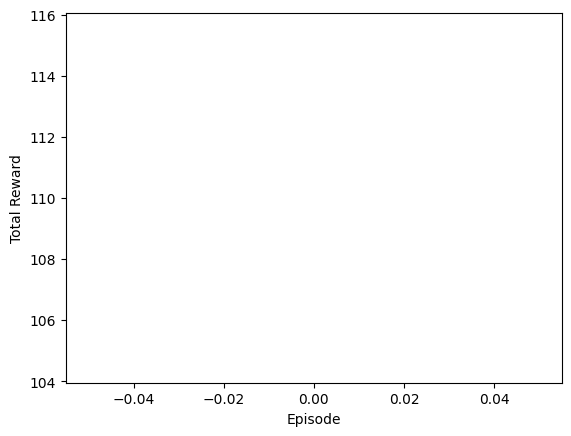

In [24]:
import matplotlib.pyplot as plt

# Inicializar lista para almacenar las recompensas por episodio
rewards = []

# Bucle de entrenamiento
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = epsilon_greedy_action(state, epsilon)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        add_experience((state, action, reward, next_state, done))

        state = next_state

        if len(replay_memory) > batch_size:
            experiences = sample_experience(batch_size)
            states, actions, rewards_, next_states, dones = zip(*experiences)

            # Convertir a tensores
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards_ = torch.FloatTensor(rewards_).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            # Actualización Q-learning
            q_values = online_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards_ + (gamma * next_q_values * (1 - dones))

            loss = criterion(q_values, target_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            # Almacenar la recompensa total de este episodio
            rewards.append(total_reward)
            break

    # Actualizar la red de destino cada N episodios
    if episode % update_target_every == 0:
        target_net.load_state_dict(online_net.state_dict())

    # Reducir epsilon
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    print(f"Episodio {episode}, Recompensa Total: {total_reward}")

# Graficar las recompensas después del entrenamiento
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa Total')
plt.title('Progreso del Entrenamiento del Agente')
plt.show()

## 10. Evaluar el Rendimiento:


In [25]:
for _ in range(10):  # Ejecuta 10 episodios de evaluación
    state, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = epsilon_greedy_action(state, 0)  # Sin exploración
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
    print(f"Recompensa total: {total_reward}")


Total reward: 244.0
Total reward: 360.0
Total reward: 490.0
Total reward: 606.0
Total reward: 736.0
Total reward: 849.0
Total reward: 967.0
Total reward: 1080.0
Total reward: 1192.0
Total reward: 1325.0
